
---

# Intro to Tensor Network Contractions
Taken from Glen Evenbly, [glenevenbly.com](https://glenevenbly.com) with some of my own edits

In this tutorial you will learn the basics of performing tensor network contractions in python. Topics include:
- the computational costs of network contractions
- network contractions via a sequence of pairwise contractions
- optimal contraction orders
- use of `xcon` function for contracting networks
- calculation of environments (or single tensor gradients) from closed networks

In [22]:
# Install glens tensor algorithm library
!pip install https://github.com/gevenbly/TensorAlgs

The folder you are executing pip from can no longer be found.


In [2]:
# Import necessary modules
from IPython.display import Image
import matplotlib.pyplot as plt
import numpy as np
import os
cwd = os.getcwd()
t_alg_wd = os.path.join(cwd, 'TensorAlgs')
os.chdir(t_alg_wd)
# %run ./network_render.ipynb
# %run ./network_contract.ipynb
from network_contract import (
    check_network, compute_costs, remove_tensor, solve_order, ncon, xcon)
from network_render import draw_network, draw_network_interactive


---

## Network contraction via index summation

Assume that we wish to contract a simple network composed of three tensors $\{A, B, C\}$ defined as follows:

\begin{equation}
{D_{inm}} = \sum\limits_{jkl} {{A_{ijk}}{B_{klm}}{C_{jnl}}} \tag{Eq.1}
\end{equation}

This network can be represented diagramatically as:
<a name="fig1"></a>
<p align="center">
<img src='https://github.com/gevenbly/TensorAlgs/blob/main/images/net3.png?raw=true' width=500px $\textrm{Fig}.(1)$ > 
</p> 
<p align = "right">
$(\textrm{Fig}.1)$ 
</p>

The simplest way to evaluate this contraction is using a set of nested for loops, with a loop for each index involved in the contraction, as shown below.



In [3]:
# evaluate using explicit index summation
def bruteforce_summation(A,B,C,d):
    D = np.zeros((d,d,d), dtype=float)
    for i in range(d):
        for n in range(d):
            for m in range(d):
                for j in range(d):
                    for k in range(d):
                        for l in range(d):
                            D[i,n,m] += A[i,j,k]*B[k,l,m]*C[j,n,l]
    return D

In [4]:
# define some random tensors
d = 5 #all tensors have dimension d=5 accross all 3 indeces
A = np.random.rand(d,d,d)
B = np.random.rand(d,d,d)
C = np.random.rand(d,d,d)

D = bruteforce_summation(A,B,C,d)

print("Shape of resulting tensor D:", np.shape(D))

Shape of resulting tensor D: (5, 5, 5)


While producing the correct result, the evaluation using index summation has several issues. 

Firstly it is verbose to code a contraction in this way, especially for networks beyond the very simple network considered in the example. A sophisticated tensor algorithm may involve networks with dozens of tensors and hundreds of indices (and coding `for` loops nested 100+ deep would not be good practice!).

Secondly, and perhaps more significantly, evaluation using index summation is also computationally inefficient. The cost of running the code snippet above scales as $d^6$ (in terms of the number of scalar multiplications), however, as we shall see shortly, the same contraction can also be performed with cost $2d^5$ when using a different method.





---

## Pairwise tensor contractions and computational costs

A better way to contract a tensor network containing $N>2$ tensors is through a sequence of $(N-1)$ pairwise tensor contractions; this is usually substantially more computationally efficient explicit index summation.

A pairwise contraction between two tensors $A$ and $B$ involves the summation over all indices shared between these two tensors, the cost of which (in terms of scalar multiplications) follows from that of the standard matrix multiplication algorithm,

<a name="eq2"></a>
\begin{equation}
\textrm{cost}:(A \times B) = \frac{{\left\| A \right\|\left\| B \right\|}}{{\left\| {A \cap B} \right\|}}, \tag{Eq.2}
\end{equation}

with $\left\| A \right\|$ and $\left\| B \right\|$ as the total dimension of each tensor, and ${{\left\| {A \cap B} \right\|}}$ as the total dimension of the indices shared between the two tensors. Following this equation, and assuming indices of dimension $d$, the cost of a vector-matrix multiplication evaluates as $d^2$, while the cost of a matrix-matrix multiplication evaluates as $d^3$, as expected.




---

**Example 1: sequences of pairwise contractions**

Consider the network of [Fig.1](#fig1), which we previously evaluated using index summation. Instead we shall now evaluate this network with a sequence of pairwise contractions, first contracting $A$ with $B$ and then contracting the product with tensor $C$. Assuming all indices are $d$ dimensional and following [Eq.2](#eq2) the contraction costs evaluate as

\begin{align}
\textrm {cost}& :(A \times B) = d^5\\
\textrm {cost}& :(\{A B\} \times C) = d^5 \tag{Eq.3}
\end{align}

where we use $\{A B\}$ to denote the tensor resulting from the product of $A$ and $B$. Thus the total contraction cost is $2d^5$, which is computationally cheaper than index summation (at total cost $d^6$) for all index dimensions $d>2$.

In practice we can use the numpy `tensordot` function to evaluate a pairwise contraction, as demonstrated in the snippet below for the evaluation of [Fig.1](#fig1). Note that one has to be careful with indew ordering; here we require explicit use of `transpose` in order to maintain an index ordering consistant with that defined in [Eq.1](#eq2).



In [5]:
def pairwise_summation(A,B,C,d):
    AC = np.zeros((d,d,d,d), dtype=float)
    for i in range(d):
        for n in range(d):
            for k in range(d):
                for l in range(d):
                    for j in range(d):
                        AC[i,n,k,l] += A[i,j,k]*C[j,n,l]
    
    D = np.zeros((d,d,d), dtype=float)
    for i in range(d):
        for n in range(d):
            for k in range(d):
                for l in range(d):
                    for m in range(d):
                        D[i,n,m] += AC[i,n,k,l]*B[k,l,m]
                            
    #we return AC to check against AC obtained with tensordot
    return D, AC

In [6]:
# Bruteforce vs pairwise summation comparison

# 1. Bruteforce explicit index summation (cost=d^6)
D_1 = bruteforce_summation(A,B,C,d)

# 2. Pairwise explicit index summation (cost=d^5)
D_2_a, AC_2_a = pairwise_summation(A,B,C,d) #AC = AC_{inkl}

# Compare
print('tensors match: %r' %(np.allclose(D_1,D_2_a)))

tensors match: True


### Pairwise contraction using _np.tensordot()_

Be careful when comparing tensors since the order of the indeces must match. Also, you must especify the axes over which the tensors are being contracted, check the convention used in Equation 1.<br>
We can go about this contraction several ways, for example:<br>
- ${D_{inm}} = {A_{ijk}}{B_{klm}}{C_{jnl}} = {AB_{ijlm}}{C_{jnl}} = {D_{imn}}$.transpose(0,2,1)
- ${D_{inm}} = {A_{ijk}}{C_{jnl}}{B_{klm}} = AC_{iknl}{B_{klm}} = D_{inm}$

In [7]:
# 2.b.1. AB first
AB_2_b_1 = np.tensordot(A, B, axes=((2), (0)))
D_2_b_1 = np.tensordot(AB_2_b_1, C, axes=((1,2), (0,2))).transpose(0,2,1)

# 2.b.2. AC first
AC_2_b_2 = np.tensordot(A, C, axes=((1), (0)))
D_2_b_2 = np.tensordot(AC_2_b_2, B, axes=((1,3), (0,1)))

# Check AC match
print('AC intermediary tensors match: %r' %(np.allclose(AC_2_b_2.transpose(0,2,1,3), AC_2_a)))

# check that the results match
print('tensors match 2.b.1: %r' %(np.allclose(D_1,D_2_b_1)))
print('tensors match 2.b.2: %r' %(np.allclose(D_1,D_2_b_2)))

AC intermediary tensors match: True
tensors match 2.b.1: True
tensors match 2.b.2: True


while use of `tensordot` to contract a network is certainly an improvement over the index summation we first considered, it is still unsatisfactory for a number of reasons. 

Firstly, for larger networks (e.g. containing 10+ tensors) it is still going to be exceptionally challenging to write the contraction as a sequence of `tensordot` operations, so we would still like to be able to use a more user-friendly and readible syntax.

Secondly is a more subtle issue; the use of `tensordot` requires hardcoding a specific contraction order. For instance in Snip.(2) above we evaluated the network as $((A\times B) \times C)$. However if we decided instead that we wanted a different order, e.g. $((A\times C) \times B)$, then the code would have to be rewritten. This is important since, as we explain in the next section, the cost of a network contraction depends on the order of contraction. Thus it is highly desirable that we avoid having to hardcode specific contraction orders, i.e. that we can change contraction order without having to rewrite code.


---

## Contraction orders

When evaluation a network containing $N>2$ tensors there are multiple different sequences of pairwise contractions that could be used. While the final resulting tensor is, of course, **independent** of the particular sequence of pairwise contractions used to produce it, the total contraction cost can depend on the chosen sequence. For instance assume that we wish to evaluate the product $(A\times B \times v)$, with $A$, $B$ as matrices and $v$ as a vector, all with index dimensions $d$. There are two different sequences that we could use to perform the contraction, each with different total costs,

\begin{align}
\textrm{cost}& :((A \times B) \times v) = {d^3} + {d^2},\\
\textrm{cost}& :(A \times (B \times v)) = {2 d^2}. \tag{Eq.4}
\end{align}

Thus for all $d>2$ we see that the second option, $(A \times (B \times v))$, is the most efficient in this example.

In general, we would always like to indentify and use the **optimal** contraction order (i.e. that with the smallest total computational cost over all possible contraction orders). For relatively small networks it may be possible to determine the optimal order through manual inspection. However, determining the optimal order in larger networks is a difficult task, one for which there is no known algorithm that scales polynomially with the number of tensors in the network. Later in this tutorial we will introduce numerical routines for solving for the optimal order, which are based on brute force searches aided with heuristics.


---

**Example 2: optimal contract orders**

Let us consider a contraction of a network of three tensors,

\begin{equation}
{D_{inm}} = \sum\limits_{jkl} {{A_{ijk}}{B_{klm}}{C_{jnl}}} \tag{Eq.5},
\end{equation}
but now assuming that indices $\{i,j,l,m \}$ are dimension $d$, and indices $\{k,n\}$ are dimension $\chi$. This network can be represented diagramatically as:
<a name="fig2"></a>
<p align="center">
<img src='https://github.com/gevenbly/TensorAlgs/blob/main/images/net5.png?raw=true' width=500px > 
</p> 
<p align = "right">
$(\textrm{Fig}.2)$ 
</p>
with black indices of dim $d$ and green indices of dim $\chi$. Let us examine the costs of evaluating this network,

\begin{align}
\textrm{cost}& :((A \times B) \times C) = {2 d^4 \chi},\\
\textrm{cost}& :((B \times C) \times A) = {2 d^3 \chi^2}, \\
\textrm{cost}& :((A \times C) \times B) = {2 d^3 \chi^2}. \tag{Eq.6}
\end{align}

This example demonstrates an intersting point: the optimal contraction order depends on not only the geometry of the network but also on the relative dimensions of the network indices. For $d<\chi$ the first order is the most efficient, while for $d>\chi$ the second or third order are better.




---

# Advanced Contractions Using XCON

In this section we demonstrate the usage of the `xcon` function (Xterme CONtractor) for contracting tensor networks. Internally, this function contracts networks via a sequence of pairwise contractions using `tensordot`, as we discussed previously in this tutorial. However use `xcon` confers several advantages over direct use of repeated `tensordot` such as:

- providing a more readible and compact means of performing efficient tensor network contractions. 

- identifying common user-errors when defining a tensor networks, thus providing valuable debugging assistance. 

- allowing the contraction order for a network to be easily changed, since order is passed to `xcon` as a variable rather than being hardcoded.
 
Note that the `xcon` network contractor is based upon the previous `ncon` contractor (Network CONtractor), and reproduces its core, functionality, but improves upon it in many significantly ways including: 

*   networks can now be defined with labels as `str`'s or as `int`'s.   
*   a solver for optimal contaction order is incorporated.
*   single tensor environments can now be automatically generated from a closed network (achieved through a smart reordering of the contraction order).  
*   intermediate terms from a contraction are automatically recycled when evaluting multiple environments from a network, greatly improving the computational efficiency as compared to an evaluation of each environment singularly.


---

## Syntax for defining networks

In order to contract the network using `ncon` we must provide the following inputs:
- `tensors`: a list of the tensors involved
- `connects`: a list of sublists, where each sublist specifies the indices appearing on a tensor (either a `str` or `int` label)
- `open_order`: (optional) a list specifying the order of the open indices that appear on the final tensor. If not provided, then `xcon` will default to that provided by `list.sort()` on the open indices.




---

**Example 3: contractions using xcon**

Let us again consider a simple network composed of three tensors: 

\begin{equation}
{D_{inm}} = \sum\limits_{jkl} {{A_{ijk}}{B_{klm}}{C_{jnl}}}, \tag{Eq.7}
\end{equation}

which can be represented diagramatically as:
<a name="fig3"></a>
<p align="center">
<img src='https://github.com/gevenbly/TensorAlgs/blob/main/images/net3.png?raw=true' width=500px > 
</p> 
<p align = "right">
$(\textrm{Fig}.3)$ 
</p>

An example of the usage of `xcon` for contracting Fig.(3) is provided below.

In [8]:
# Snip.(3): contraction of Fig.(3) via xcon

# define some random tensors
d = 5
A = np.random.rand(d,d,d)
B = np.random.rand(d,d,d)
C = np.random.rand(d,d,d)

# contraction via index summation
D = bruteforce_summation(A,B,C,d)

# contraction via xcon
tensors = [A,B,C]
connects = [['i','j','k'], ['k','l','m'], ['j','n','l']]
open_order = ['i','n','m']
D0 = xcon(tensors, connects, open_order=open_order)

# check that the two methods produce the same result
print('tensors match: %r' %(np.allclose(D,D0)))

tensors match: True


Notice that the index labels $\{i,j,k,\ldots \}$ used to define the contracion in Eq.(7) are **dummy** indices; they have no specific meaning in themselves, their function is simply to denote which pairs of indices are contracted together. Thus we could potentially rename these indices to whatever we like without changing the definition of the network itself. 

One common convention (which was **required** by the previous `ncon` routine) is to label the contracted (or internal) indices of a network with positive integers $[1,2,3,\ldots]$ and the open (or external) indices of a network with (semi) negative integers $[-0,-1,-2,\ldots]$ in the order in which they appear on the final tensor. The use of these **standardized** labels has the advantage in that it removes the need for the `open_order` input, since this information is instead encoded by the order of the negative integers. Below we demonstrate these different conventions for the contraction of Fig.(3).


In [9]:
# contraction using standardized external indices (no `open_order` needed!)
connects = [[-0,'j','k'], ['k','l',-2], ['j',-1,'l']]
D1 = xcon(tensors, connects)

# contraction using standardized external and internal indices
connects = [[-0,1,3], [3,2,-2], [1,-1,2]]
D2 = xcon(tensors, connects)

# check that the two methods produce the same result
print('tensors match: %r' %(np.allclose(D0,D1) and np.allclose(D0,D2)))

tensors match: True



---

**Example 4: partial traces and outer products**

The `xcon` routine can also be used for networks containing partial traces and tensor products, thus can also effectivly replace such numpy functions such as `np.outer` and `np.kron`. We demonstrate this functionality with a simple example network:

\begin{equation}
{D_{jlkn}} = \sum\limits_{im} {{A_{ijik}}{B_{lm}}{C_{mn}}}, \tag{Eq.8}
\end{equation}

which is represented diagramatically as

<a name="fig4"></a>
<p align="center">
<img src='https://github.com/gevenbly/TensorAlgs/blob/main/images/net6.png?raw=true' width=300px $\textrm{Fig}.(4)$ > 
</p> 
<p align = "right">
$(\textrm{Fig}.4)$ 
</p>

and provide the `xcon` usage below.

In [10]:
# Snip.(5): partial traces and outer products

# define some random tensors
d = 5
A = np.random.rand(d,d,d,d)
B = np.random.rand(d,d)
C = np.random.rand(d,d)

# evaluate using explicit index summation
D = np.zeros((d,d,d,d), dtype=float)
for j in range(d):
  for l in range(d):
    for k in range(d):
      for n in range(d):
        for i in range(d):
          for m in range(d):
            D[j,l,k,n] += A[i,j,i,k]*B[l,m]*C[m,n]

# evaluate using xcon
tensors = [A,B,C]
connects = [['i','j','i','k'], ['l','m'], ['m', 'n']]
open_order = ['j', 'l', 'k', 'n']
D0 = xcon(tensors, connects, open_order=open_order)

# check that the two methods produce the same result
print('tensors match: %r' %(np.allclose(D,D0)))

tensors match: True



---

## Contraction orders and costs

Internally the `xcon` routine contracts networks through a sequence of pairwise tensor contractions. There are three options determining the order that `xcon` can use:
- one can provide an `order` input, consisting of a list of the internal indices in the order that they should be contracted.
- one can input a `solver` argument to call the inbuilt solver, which can automatically determine an efficient contraction order. The are several options how the solver can be employed:

 1. setting `solver='full'` will search over all viable orders to provide the gauranteed optimal order. This can require significant time for larger networks (i.e. 12 or more tensors). 

 2. setting `solver='greedy'` will search only the locally optimal contraction orders (i.e. using a greedy algorithm). This search is always essentially instantaneous, but is not gauranteed to produce an optimal order. 

 3. setting `solver` as equal to an integer will use the integer value as an upper bound for the number of branches searched at each step of the search algorithm, which serves to allow itermediate settings between `'greedy'` and `'full'`. In the limit that the integer value is taken to $1$ the `'greedy'` result is reproduced, while in the limit of a large value, i.e. $O(exp(N))$ with $N$ the number tensors in the network, the `'full'` result is reproduced. 

- one can omit both an `order` and a `solver` argument, in which case `xcon` defaults to an order based on a `list.sort` of the internal index labels.

Note that, by setting the optional `xcon` argument `return_info=True`, then `xcon` will return the contraction `order` and the computational `cost` of the network contraction in addition to the tensor from the contracted network. The return of the `order` can be used to avoid having to call the `solver` multiple times on the same network, which is otherwise inefficient.  




---

**Example 5: optimal contract orders**

Let us reconsider the network from Example 2,

\begin{equation}
{D_{inm}} = \sum\limits_{jkl} {{A_{ijk}}{B_{klm}}{C_{jnl}}} \tag{Eq.8},
\end{equation}
where indices $\{i,j,l,m \}$ are dimension $d$, and indices $\{k,n\}$ are dimension $\chi$. This network is represented diagramatically as:
<a name="fig4"></a>
<p align="center">
<img src='https://github.com/gevenbly/TensorAlgs/blob/main/images/net5.png?raw=true' width=500px > 
</p> 
<p align = "right">
$(\textrm{Fig}.4)$ 
</p>

with black indices of dim $d$ and green indices of dim $\chi$. Recall from Eq.(6) that for $d<\chi$ the optimal contraction order was found to be $((A \times B) \times C)$ which had cost ${2 d^4 \chi}$. 

This order can be input into `xcon` by setting `order = ['k', 'j', 'l']`, which informs that index $k$ should be the first to be contracted, followed by $j$ and $l$. Note that `xcon` always simultaneously contracts all of indices shared between the two tensors in a pairwise contraction. Thus setting `order = ['k', 'l', 'j']` would also be exactly equivalent, since in the contraction of the group $\{ AB \}$ with $C$ both indices $j$ and $l$ are contracted simultaneously.

We demonstrate below how the known order can be directly set in `xcon` and, alternatively, how the solver could instead be used to determine the order.




In [11]:
# Snip.(6): efficient contraction order

# generate the tensors
d = 5
chi = 10
A = np.random.rand(d,d,chi)
B = np.random.rand(chi,d,d)
C = np.random.rand(d,chi,d)
tensors = [A,B,C]

# ------------------------------
# (a) Example: contract using known order
connects = [[-1,'j','k'], ['k','l',-3], ['j',-2,'l']]
order = ['k', 'j', 'l']
D0, order0, cost0 = xcon(tensors, connects, order=order, return_info=True)

# we can check that the cost matches the theoretical prediction
cost_exact = int(2*(d**4)*chi)
print('actual cost: %d, theory cost: %d' %(cost0, cost_exact))


# ------------------------------
# (b) Example: contract using implicitly defined order: `order = [1,2,3]`
connects = [[-1,2,1], [1,3,-3], [2,-2,3]]
D2 = xcon(tensors, connects)


# ------------------------------
# (c) Example: use solver to find the optimal order
connects = [[-1,'j','k'], ['k','l',-3], ['j',-2,'l']]
D1, order1, cost1 = xcon(tensors, connects, solver='full', return_info=True)

# we can check that the cost matches the theoretical prediction
cost_exact = int(2*(d**4)*chi)
print('actual cost: %d, theory cost: %d' %(cost1, cost_exact))

# check that the output order matches our expectations
print('order determined from solver: ', order1) 

# note that the output order can be reused for effecient future contractions
D1 = xcon(tensors, connects, order=order1)


actual cost: 12500, theory cost: 12500
actual cost: 12500, theory cost: 12500
order determined from solver:  ['k', 'j', 'l']



---

## Use of the order solver

The solver for optimal contraction order can also be used separately from `xcon` by calling `solve_order`, which takes similar inputs to `xcon` but only finds the `order` rather than contracting a network. This can be useful, for instance, in exploring the contraction costs in the design of a new tensor network algorithm. 

The `solve_order` routine takes input of `tensors` and `connects` just as `xcon` does, however the `tensors` can here be either the list of tensors as usual **or** it can be a list of the shapes of each tensor (i.e. as tuples). An optional integer `max_branch` can be provided in order to limit the scope of the search: 
- omitting `max_branch` reproduces the `solver='full'` search from `xcon`.
- setting `max_branch=1` reproduces the `solver='greedy'` search from `xcon`.  

In addition to the `order` the solver also returns the ($\textrm{log}_{10}$ of) the contraction cost and a boolean flag indicating whether the returned order in guaranteed optimal (which may be `False` if the `max_branch` is set too small).



---

**Example 6: order solver**

Let us reconsider the network from Example 5 using the `solve_order` routine:

In [12]:
# Snip.(7): solve for the order

# set the dims
d = 5
chi = 10
dims = [(d,d,chi), (chi,d,d), (d,chi,d)]

# ------------------------------
# (a) Example: contract using known order
connects = [[-1,'j','k'], ['k','l',-3], ['j',-2,'l']]
order, log_cost, is_optimal = solve_order(dims, connects, max_branch=1000)

# examine the outputs
print('order determined from solver: ', order) 
cost_exact = int(2*(d**4)*chi)
print('actual cost: %d, theory cost: %d' %(np.round(10**log_cost), cost_exact))
print('guaranteed optimal: ', is_optimal) 

order determined from solver:  ['k', 'j', 'l']
actual cost: 12500, theory cost: 12500
guaranteed optimal:  True



---

## Examination of cost scaling

Although `xcon` can return the numeric cost of a contraction given tensors of some specific dimensions, often we are more interested in knowing how this cost **scales** as a function of the index dimensions. To this end the `compute_costs` routine is useful; if provided a list of tensor shapes it will produce a list specifying individual cost of each of the pairwise contractions required to contract the network.

Here the dims can be provided either as numeric values (as `int`) or symbolically (as `str`), or as a mixture of both. If symbolic dims are provided then symbolic costs are returned. 


---

**Example 7: cost scaling analysis**

Let us reconsider the cost scaling of network from Example 5 using the `compute_costs` routine. Recall that we determined analytically that this network required two pairwise contractions, each of cost ${d^4 \chi}$, to contract. The `compute_costs` routine can reproduce this scaling result: 

In [13]:
# Snip.(8): solve for costs

# define the network and order
connects = [[-1,'j','k'], ['k','l',-3], ['j',-2,'l']]
order = ['k', 'j', 'l']

# investing cost scaling as function of `d` and `chi`
dims_symbolic = [('d','d','chi'),('chi','d','d'),('d','chi','d')]
symbolic_costs = compute_costs(connects, order=order, dims=dims_symbolic)
print('cost scaling: ', symbolic_costs)

# investing cost scaling as function of `chi` with d=5 held fixed 
d = 5
dims_mixed = [[d,d,'chi'],['chi',d,d],[d,'chi',d]]
mixed_costs = compute_costs(connects, order=order, dims=dims_mixed)
print('cost scaling: ', mixed_costs)

cost scaling:  ['(d^4)(chi^1)', '(d^4)(chi^1)']
cost scaling:  ['625*(chi^1)', '625*(chi^1)']



---

## Network consistancy checking

Often it is very easy to make a mistake when defining a complicated network. The `xcon` routine contains the ability to identify several types of error in network definitions, including mismatches in index dimensions and incorrectly labelled indices. This functionality is disabled by default (to minimize the computational overhead) but can be enabled by setting the optional input `perform_check=True`. The network checking function `check_network` can also be called separately outside of `xcon` if needed. Of course there are also many types of error that cannot be identified in the checker: just because a network passes the checks does not necessarily mean that it is the correct network that you intended!


---

**Example 8: identification of user error**

Consider the network below, which is used in the optimization of a $1D$ variational MERA:
<a name="fig5"></a>
<p align="center">
<img src='https://github.com/gevenbly/TensorAlgs/blob/main/images/net7.png?raw=true' width=300px > 
</p> 
<p align = "right">
$(\textrm{Fig}.5)$ 
</p>

This network, while significantly more complex that the previous example networks considered in this tutorial, is typical of what may be encountered in a practical algorithm. Inputting this network into `xcon` is a tricky prospect; it would be very easy to make a small error in the network definition. In the code below we demonstrate how `xcon` can identify such an error.

In [14]:
# Snip.(9): network consistancy checking

# initialize some random tensors
chi = 4
chimid = 3
u = np.random.rand(4,4,3,3)
w = np.random.rand(3,3,4)
ham = np.random.rand(4,4,4,4,4,4)
rho = np.random.rand(4,4,4,4,4,4)

# define a network (from 1D binary MERA)
tensors = [u,u,w,w,w,ham,u,u,w,w,w,rho]
connects = [[1, 3, 10, 11], [4, 7, 12, 13], [8, 1, 21], [11, 12, 22],
            [13, 14, 23], [2, 5, 6, 3, 4, 7], [1, 2, 9, 17], [5, 6, 16, 15],
            [8, 9, 18], [17, 16, 19], [15, 14, 20], [18, 19, 20, 21, 22, 23]]
order = [4,7,5,6,12,11,3,1,2,17,16,8,10,9,14,13,15,18,19,20,21,22,23]

# the above network definition contains an error, can you spot it? No?
# Then its a good thing that the checker in `xcon` can spot the error:
tensor_out = xcon(tensors, connects, order=order, perform_check=True)

# this returns the error message:
# 'ValueError: Network definition error: more than two indices labelled `1`'
#
# it turns out that the third tensor was mislabelled with a `1` instead of `10`,
# the correct labelling is: [8, 1, 21] -> [8, 10, 21]


# alternatively we could have called the network checker on its own
dims = [tensor.shape for tensor in tensors]
check_network(connects, dims, order)

ValueError: Network definition error: more than two indices labelled `1`

In [15]:
chi = 4
chimid = 3
u = np.random.rand(4,4,3,3)
w = np.random.rand(3,3,4)
ham = np.random.rand(4,4,4,4,4,4)
rho = np.random.rand(4,4,4,4,4,4)

# define a network (from 1D binary MERA)
tensors = [u,u,w,w,w,ham,u,u,w,w,w,rho]
connects = [[1, 3, 10, 11], [4, 7, 12, 13], [8, 10, 21], [11, 12, 22],
            [13, 14, 23], [2, 5, 6, 3, 4, 7], [1, 2, 9, 17], [5, 6, 16, 15],
            [8, 9, 18], [17, 16, 19], [15, 14, 20], [18, 19, 20, 21, 22, 23]]
order = [4,7,5,6,12,11,3,1,2,17,16,8,10,9,14,13,15,18,19,20,21,22,23]

dims = [tensor.shape for tensor in tensors]
check_network(connects, dims, order)

tensor_out = xcon(tensors, connects, order=order, perform_check=True)
print("Tensor network result:", tensor_out)

Tensor network result: 590833395.8069499



---

## Network visualization

We can make network diagrams in python by making use of the `draw_network` routine from the `network_renderer` module (see the [Guide](https://colab.research.google.com/drive/1TIWa_UApRIL8ZxJc16fyBKtO1IyhH3qN?usp=sharing) for full instructions). The renderer takes the same `connects` input as `xcon`, but can also accept extra optional arguments such as tensor `names` to further decorate the diagram. The render can also perform the same checks as the `check_network` routine and can display the same computational costs as `compute_costs`.



---

**Example 9: network diagram in python**

In this example we recreate the network from Fig.(4) using the network renderer.

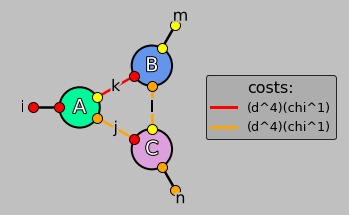

In [16]:
# Snip.(10): network diagrams

# define xcon info for the network from Fig.(4)
dims = [['d','d','chi'],['chi','d','d'],['d','chi','d']]
connects = [['i','j','k'], ['k','l','m'], ['j','n','l']]
order = ['k','j','l']
open_order = ['i','n','m']

# define the tensor names
names = ['A','B','C']

# draw the networks 
fig = draw_network(connects, names=names, order=order, dims=dims, 
                   open_order=open_order, show_costs=True)


---

## Single-tensor environments

Imagine that we have a closed network (i.e. a network with no open indices) comprised of a set of tensors $\{A,B,C,\ldots \}$ which when contracted evaluates to a scalar $c$. We define an environment $\Gamma_A$ as the tensor that would be obtained from contacting the network with tensor $A$ removed from it. It follows that the contraction of matching indices from tensor $A$ with its environment $\Gamma_A$, which we denote using the tensor-trace '$\textrm{tTr}$', evaluates to the scalar $c$,

\begin{equation}
\textrm{tTr}(A, \Gamma_A) = c. \tag{9}
\end{equation}

The calculation of tensor environments, which may be understood as the derivative of the network with respect a single tensor, is often a key part of network optimization strategies. In many cases we may be interested varying the parameters contained in some tensor $A$ as to maximise (or minimise) the scalar $c$ associated to the closed network, which is easily achieved if the environment $\Gamma_A$ is known.

In Fig.(6) below we depict a closed network (relating to the optimization of a $1D$ binary MERA) and the enviornment of the $h$ from within this network. 

<a name="fig6"></a>
<p align="center">
<img src='https://github.com/gevenbly/TensorAlgs/blob/main/images/net8.png?raw=true' width=600px > 
</p> 
<p align = "right">
$(\textrm{Fig}.6)$ 
</p>

In many tensor algorithms it is required to compute many different single tensor environments from the same network. For instance, the optimization algorithm for a $1D$ binary MERA requires one to compute a total of seven different environments from the network in Fig.(6). One could could these compute each environment separately by (i) defining a separate network for each environment, (ii) solving each network for the optimal contraction order, (iii) contracting each environment network separately. However, given the importance of the calculation of environments for tensor algorithms, the `xcon` routine has been designed to automate these task, without the need for the user to consider environment networks separately. 

Let us assume that we have a closed network of $N$ tensors with some known contraction order, such that it can be contracted to a scalar with cost $\kappa$. Then, after setting the optional input `which_envs = r` for some intger $r < N$, the `xcon` routine will return the environment of the $r^\textrm{th}$ tensor. Importantly `xcon` can automatically determine the proper contraction order for the environment, such that the contraction cost remains at $\kappa$, even though the order required for the environment may be very different to the order required for the closed network.

One can also set `which_envs` as a list of integers, e.g. `which_envs = [0, 3, 4]`, which will return a list of the corresponding tensor environments. It should be noted that computing multiple environments simultaneously is generally much more efficient than computing the same environments sequentially (i.e. one at a time), since `xcon` is able to reuse many of the intermediate tensors when contracting for multiple environments.  



---

**Example 10: tensor environments**

In this example we evaluate some tensor environments from the network in Fig.(6):

In [17]:
# Snip.(11): Tensor environments

# define some random tensors
chi = 4
chimid = 3
w = np.random.rand(chimid, chimid, chi)
u = np.random.rand(chi,chi,chimid,chimid)
h = np.random.rand(chi,chi,chi,chi,chi,chi)
rho = np.random.rand(chi,chi,chi,chi,chi,chi)

# define the closed network from Fig.(6)
tensors = [u, u, w, w, w, h, u, u, w, w, w, rho]
connects = [[1, 3, 10, 11], [4, 7, 12, 13], [8, 10, 21], [11, 12, 22],
            [13, 14, 23], [2, 5, 6, 3, 4, 7], [1, 2, 9, 17], [5, 6, 16, 15],
            [8, 9, 18], [17, 16, 19], [15, 14, 20], [18, 19, 20, 21, 22, 23]]

# solve closed network for optimal order, then contract to a scalar 
scalar_out, order, cost = xcon(tensors, connects, return_info=True, 
                               solver='full')

# evaluate the environment of the `h` tensor
env_h = xcon(tensors, connects, order=order, which_envs=5)
# check that the contraction of `h` with `env_h` matches the scalar
scalar_out0 = np.inner(env_h.flatten(), h.flatten())
print('Full closed contraction and env_h with h contractions match: %r' %(np.allclose(scalar_out, scalar_out0)))

# evaluate the environments of the each of the six `w` tensors 
envs_w = xcon(tensors, connects, order=order, which_envs=[2,3,4,8,9,10])
# check that the contraction of `w` with each of the envs matches the scalar
for env in envs_w:
  scalar_temp = np.inner(env.flatten(), w.flatten())
  print('(different environments) scalars match: %r' %(np.allclose(scalar_out, scalar_temp)))


Full closed contraction and env_h with h contractions match: True
(different environments) scalars match: True
(different environments) scalars match: True
(different environments) scalars match: True
(different environments) scalars match: True
(different environments) scalars match: True
(different environments) scalars match: True
